<a href="https://colab.research.google.com/github/alexngocvu/Heart-Disease-and-Lifestyle/blob/main/Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- 1. DATA LOADING & PREP: ALL FEATURES ---
Uploading file (heart_2020_cleaned.csv)...


Saving heart_2020_cleaned.csv to heart_2020_cleaned (3).csv
Loaded data shape: (319795, 18)
Shape before final dropna: (319795, 33)
Shape after final dropna: (319795, 33)
Total features used in the model: 32

--- 2. SCALING AND SPLITTING ---
Training on 255836 samples.

--- 3. HIGH-ACCURACY MODELING (Random Forest) ---

--- 4. EVALUATION ---
AUC-ROC Score (Full Features): 0.8256 (Measures discrimination power)
Classification Report:
               precision    recall  f1-score   support

       No HD       0.97      0.79      0.87     58484
      Has HD       0.24      0.70      0.36      5475

    accuracy                           0.78     63959
   macro avg       0.60      0.74      0.61     63959
weighted avg       0.90      0.78      0.83     63959


Top 10 Feature Importance Scores:
                    Feature  Importance
9                 GenHealth    0.199030
6               DiffWalking    0.080793
7                  Diabetic    0.069737
25  AgeCategory_80 or older    0.065185


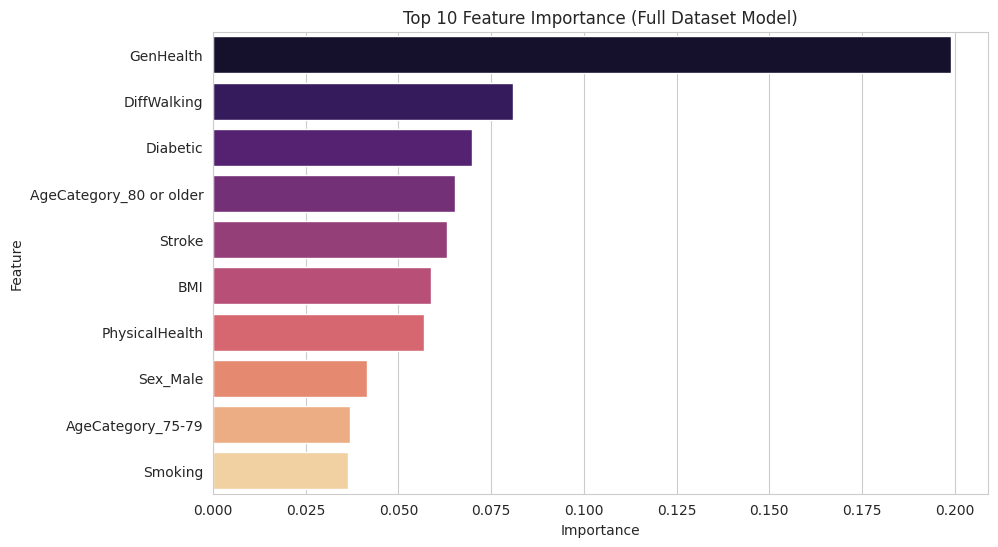

--------------------------------------------------


In [1]:
import warnings
warnings.filterwarnings('ignore')

# Core Data Science Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Modules for Preprocessing, Modeling, and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

# --- 1. DATA LOADING AND COMPREHENSIVE PREPROCESSING ---
print("--- 1. DATA LOADING & PREP: ALL FEATURES ---")

TARGET = 'HeartDisease'

# Load the data (Must be executed in your Colab environment)
try:
    from google.colab import files
    print("Uploading file (heart_2020_cleaned.csv)...")
    uploaded = files.upload()
    df_full = pd.read_csv('heart_2020_cleaned.csv')
except ImportError:
    # Fallback for local Jupyter/IDE environments
    print("Assuming 'heart_2020_cleaned.csv' is in the current directory.")
    try:
        df_full = pd.read_csv('heart_2020_cleaned.csv')
    except FileNotFoundError:
        print("ERROR: File not found. Please ensure 'heart_2020_cleaned.csv' is uploaded or in the path.")
        exit()

print(f"Loaded data shape: {df_full.shape}")

# A. Convert TARGET and Simple Binary Features (Yes/No to 1/0)
binary_map = {'Yes': 1, 'No': 0}
# Removed 'Sex' from binary_cols
binary_cols = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking',
               'Asthma', 'KidneyDisease', 'SkinCancer', 'PhysicalActivity']

for col in binary_cols + [TARGET]:
    if col in df_full.columns:
        # Check for unmapped values before mapping
        unmapped_values = set(df_full[col].unique()) - set(binary_map.keys())
        if unmapped_values:
            print(f"WARNING: Unmapped values found in column '{col}': {unmapped_values}. These rows will be dropped.")

        df_full[col] = df_full[col].map(binary_map, na_action=None)


# B. Ordinal Encoding for GenHealth (Poor=0, Excellent=4)
genhealth_order = ['Poor', 'Fair', 'Good', 'Very good', 'Excellent']
genhealth_map = {val: idx for idx, val in enumerate(genhealth_order)}
if 'GenHealth' in df_full.columns:
    # Check for unmapped values before mapping
    unmapped_values = set(df_full['GenHealth'].unique()) - set(genhealth_map.keys())
    if unmapped_values:
        print(f"WARNING: Unmapped values found in column 'GenHealth': {unmapped_values}. These rows will be dropped.")

    df_full['GenHealth'] = df_full['GenHealth'].map(genhealth_map, na_action=None)


# C. Handle 'Diabetic' (Multiple categories to binary/low risk)
diabetic_map = {
    'Yes': 1,
    'No': 0,
    'No, pre-diabetes': 0,
    'Yes (during pregnancy)': 1,
    'No, borderline diabetes': 0 # Added borderline diabetes
}
if 'Diabetic' in df_full.columns:
    # Check for unmapped values before mapping
    unmapped_values = set(df_full['Diabetic'].unique()) - set(diabetic_map.keys())
    if unmapped_values:
        print(f"WARNING: Unmapped values found in column 'Diabetic': {unmapped_values}. These rows will be dropped.")

    df_full['Diabetic'] = df_full['Diabetic'].map(diabetic_map, na_action=None)


# D. ONE-HOT ENCODING for Multi-Class Categorical Features (Race, AgeCategory, Sex)
# Added 'Sex' to columns for one-hot encoding
df_full = pd.get_dummies(df_full, columns=['AgeCategory', 'Race', 'Sex'], drop_first=True, dtype=int)


# E. Final Clean up and NaN removal
print(f"Shape before final dropna: {df_full.shape}")
df_full.dropna(inplace=True)
print(f"Shape after final dropna: {df_full.shape}")

if df_full.shape[0] == 0:
    print("\nCRITICAL ERROR: DataFrame is empty after cleanup. Check your mapping dictionaries for missing values.")
    exit()

# Define X (all processed columns except the target) and y
y = df_full[TARGET]
X = df_full.drop(columns=[TARGET]) # X now contains all features

FINAL_FEATURES = X.columns.tolist()
print(f"Total features used in the model: {len(FINAL_FEATURES)}")


# --- 2. SCALING AND SPLITTING ---
print("\n--- 2. SCALING AND SPLITTING ---")

# Scaling (now safe because we checked df_full.shape[0] > 0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=FINAL_FEATURES, index=X.index)

# Stratified split is vital due to the imbalance
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training on {X_train.shape[0]} samples.")


# --- 3. HIGH-ACCURACY RANDOM FOREST MODELING ---
print("\n--- 3. HIGH-ACCURACY MODELING (Random Forest) ---")

# Increased complexity and balanced weights for best performance
rf_model_full = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    random_state=42,
    class_weight='balanced', # Essential for the imbalanced target
    n_jobs=-1
)
rf_model_full.fit(X_train, y_train)


# --- 4. EVALUATION AND FEATURE IMPORTANCE ---
print("\n--- 4. EVALUATION ---")

# Prediction and metrics
y_proba = rf_model_full.predict_proba(X_test)[:, 1]
y_pred = rf_model_full.predict(X_test)

auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC-ROC Score (Full Features): {auc_score:.4f} (Measures discrimination power)")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['No HD', 'Has HD']))

# Feature Importance
importance_df = pd.DataFrame({
    'Feature': FINAL_FEATURES,
    'Importance': rf_model_full.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10) # Show Top 10

print("\nTop 10 Feature Importance Scores:")
print(importance_df)

# Visualize Top 10 Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='magma')
plt.title('Top 10 Feature Importance (Full Dataset Model)')
plt.show()
print("-" * 50)